[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/keras_nlp.ipynb)

## Keras accuracy/performace limitations

## Pretraining autoencoder or LM will surely help.

see late review here: https://thegradient.pub/author/sebastian
and autoencoder (which is less recommended than LM here: "Semi-supervised Sequence Learning" 2015. They use one RNN for both encoder and decoder)


### CuDNNLSTM vs LSTM 
The former trains very fast on GPU, but does not support the attributes: dropout,recurrent_dropout,which are the STOA regulaizers. This is cuda problem, and even native TF does not support it

### Tip to self:
* manually check loss value on one sample (predict vs gt). From doing this, I saw <s> was not given one-hot-value

In [0]:
# adaptation of: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# first Dataset class to load bible-data
# then copy of the model, but working with words instead of chars

# Dataset

In [185]:
## NLP preprocessing for text
# has few parts:
# 1. load zip files and then use glob to filter part of them (data/*/*.txt)
# 2. parse each row into (x,y) by passing a parser method. it can be simple as lambda line:line:x, or if you use tab delimited lambda line: line.split(',')[4]
# 3. tokenize - split by spaces, but also by ., and be smart about it.  ('...' should be one token , "ai'nt" one token. then; should be two 'token' and ';')
#    you should also build vocabulary, keep X words and throw away rare ones, they will be replaced by <oov> flag.
# 4. transform text to sequences for the result. for words there are usually two different types: ['s>','hello', 'world'] -> [0,5,6] but there is also 
#     a one-hot-econding version where 5 is actaully a vector of size voc-length full of zeros, with 5th index==1.
#    The one-hot ecoding is used as output for text-generation and has a HUGE MEMORY requirement.  100K sentences of size 20 words need 2M floats = 8MB
#    But for the one-hot-encoding multiply this by vocab-size. for char-encoding it's ~30 , for good vocab of 10K words, we need 80GB(!)
#    The simple, and only , way to solve this , is to never keep one-hot-encoding in memory, just use a generator to make it one-hot in runtime



from __future__ import print_function

import numpy as np
import os
import glob
import csv, json
from collections import namedtuple
from zipfile import ZipFile
from os.path import expanduser, exists
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


TVT = namedtuple('TVT',['train','val','test'])

class Dataset:
  #Dataset for COPY encoder-decoder
  # to David: generator x,y where x is batch,max-words of type integer. (            <s>   hello word)
  #                               y is batch,max-words,one-hot-encoding (offset one: hello world <end>)
  # tokenizer is currently very bad. replace it
  # vocabulary (training-only) , don't use 666 , use large number (10K?)
  
  # Dataset2 for style, x is sentence + STYLE(one-hot-encoding of integer) , y is one hot encoding 
  
  # Dataset3 for classifier: x is sentence + STYLE(one-hot-encoding of integer),  output: STYLE(one-hot-encoding of integer)
  
  
  
  def __init__(self,unique_name,url,extract,cache_dir,pattern,skip_first,row_parser,validation_pattern=0.1,test_pattern=0.1):
    '''
    unique_name will be used for the dataset source(or zip) file. 
    pattern need to include path inside zip (including zip root)
    extract - is it zipped/tarred or not
    cache_dir - under which the files be downloaded <cache_dir>/datasets/<unique_name>
    pattern - glob will be done to choose only those files ,for example data*.txt. This should incldude both train and test
    validation - subset glob pattern to use. If it's a float like 0.1, use it as split of one file
    test - see above
    '''
    if not extract and pattern:
      raise ValueError('pattern must be empty if extract=False chooses a subset of the files (data/*.txt). but you downloaded only one file')

    if not os.path.exists(cache_dir):
       os.makedirs(cache_dir)

    fpath=get_file(unique_name, url,extract=True, cache_dir=cache_dir)
    print ('fpath',fpath)
    files = [fpath] if not pattern else glob.glob(f'{cache_dir}/datasets/{pattern}')

    train,val,test=[],[],[]
    for f in files:
      lines = [row_parser(f,line.rstrip()) for line in open(f,encoding="latin-1").readlines()] 
      lines = lines[1 if skip_first else 0:][:10000]
      print ('HARDCODED MAX LINES = 10000')
      
      print (files,'#lines',len(lines),'first 3 lines')
      print (lines[0],'\n',lines[1],'\n',lines[2])
      
      if isinstance(validation_pattern,float) and isinstance(test_pattern,float):
        test_count = int(len(lines)*(1-validation_pattern))
        val_count =  int(len(lines)*(1-test_pattern-validation_pattern))
        print ('(val_count,test_count)',val_count,test_count)
        train+= lines[:val_count]
        val+=   lines[val_count:test_count]
        test+=  lines[test_count:]
        
    self.tvt_lines = TVT(train, val, test)
    print ('train:',len(self.tvt_lines.train),'val',len(self.tvt_lines.val),'test',len(self.tvt_lines.test))
    self.parsed= self.tvt_lines
  
  
  def fit(self):
    """ the current implementation is quite bad, hello world! will be 2 tokens world! is the second. 
    """
    print ('limiting num_words in Tokenizer due to MEMORY BOUNDS')  #num_words =100*1000

    
    # I use here tokenizer only to count freq. of words, then manually choose most freq. and manually split
    # this is bad. There are better ways to do it (probably library/code which do it in one line)
    print ('\nREPLACE ME . BAD TOKENIZER!!!')
    self.tokenizer = Tokenizer(num_words=100000, filters='', lower=False, split=' ', char_level=False, oov_token='<oov>')
    
    # self.parsed.train is a list , each value is tuple text_string,file_name
    self.tokenizer.fit_on_texts([x for x,style in self.parsed.train])
    self.styles = set([style for x,style in self.parsed.train])
    print ('styles',self.styles)
    self.style2index = {style:i for i,style in enumerate(self.styles)}
    self.index2style = {index:style for style,index in self.style2index.items() }
    print (self.style2index,self.index2style)
    
    print ('\n word_index',len(self.tokenizer.word_index),'<oov>',self.tokenizer.word_index['<oov>'])
    print ('common',list(self.tokenizer.word_index.items())[:15])
    print ('uncommon',list(self.tokenizer.word_index.items())[-15:])
  
    num_words= 2000
    print ('keeping only ',num_words,'of',len(self.tokenizer.word_index))
           
           
    word2index = dict(list(self.tokenizer.word_index.items())[:num_words-len(self.styles)-2])
    word2index['<s>']=0  #keras tokenizer keeps 0 unused
    for i,style in enumerate(self.styles):
      word2index[style]=num_words-1-len(self.styles)+i  #if num_words=100 . [96,97,98] 
    word2index['<oov>']=num_words-1                   #<oov> is [99]
    print ('word2index',len(word2index))
    
    #FOR NOW the start and end are both ZERO. maybe not good???
    
    num_encoder_tokens = num_decoder_tokens= num_words # len(self.tokenizer.word_index)
    self.word2index = word2index
    self.index2word = {index:word for (word,index) in self.word2index.items()}
    self.MAX_SEQUENCE_LENGTH=10
    
    verbose=5
    result = []
    for rows in self.parsed:

      encoder_input_data  = np.zeros( (len(rows), self.MAX_SEQUENCE_LENGTH),    dtype='float32')
      decoder_input_data  = np.zeros( (len(rows), self.MAX_SEQUENCE_LENGTH),    dtype='float32') # shifted by 1
      decoder_target_data = np.zeros((len(rows),  self.MAX_SEQUENCE_LENGTH, num_decoder_tokens),    dtype='float32')
      style_data          = np.zeros((len(rows),  len(self.styles)),    dtype='float32') #one-hot
      
      #input to decoder   <s> hello world
      #target of decoder: hello world <s>
      
      for i, (input_text,style) in enumerate(rows):
        input_text = input_text.split(' ') #BUG: we need to use tokenizer here!!!!
        #pad with end token  hello world <end> <end> <end>
        end_token='<s>'
        input_text += [end_token for _ in range(self.MAX_SEQUENCE_LENGTH - len(input_text)+1)]
        if verbose:
          print ('input_text',input_text)
          verbose-=1
        # out : hello  world  <end>  (MAX_SEQUENCE_LENGTH=2)  <-encoder_input+ decoder_output(but one-hot)
        #
        # in: : <s>   hello   world  <- decoder-input
         
        for t, word in enumerate(([style]+input_text)[:self.MAX_SEQUENCE_LENGTH]):
            one_hot = word2index['<oov>'] if word not in word2index else word2index[word]
            decoder_input_data[i, t ] = one_hot
            
        for t,word in enumerate(input_text[:self.MAX_SEQUENCE_LENGTH]):  #last must be <end>=<s> token
            one_hot = word2index['<oov>'] if word not in word2index else word2index[word]
            encoder_input_data[i,t]=one_hot
            decoder_target_data[i, t, one_hot] = 1. 
            
        style_data[i,self.style2index[style]]= 1
        
      print (decoder_target_data.sum(),len(rows)*self.MAX_SEQUENCE_LENGTH)
      assert int(decoder_target_data.sum())==len(rows)*self.MAX_SEQUENCE_LENGTH #one-hot-encoding must always include one
      
      result.append( (encoder_input_data,decoder_input_data,decoder_target_data,style_data))

    self.result= TVT(*result)

  def one_x_as_text(self,x):
    """ 1x20 or 20 input"""
    if len(x.shape)==2: 
      assert x.shape[0] ==1  #can only work on batch of 1
      x= x[0]
    return ' '.join([self.index2word[index] for index in x])

  def one_y_as_text(self,y):
    """ 1x20x2000 or 20x2000 input, in case of first will work on y[0]"""
    if len(y.shape)==3: 
      assert y.shape[0] ==1  #can only work on batch of 1
      y=y[0]
      
    best_token = np.argmax(y,1)
    return ' '.join([self.index2word[index] for index in best_token])

  
cache_dir='cache' 
#dataset('quora_dups','http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv',False,cache_dir) 
#dataset('bible4','https://codeload.github.com/keithecarlson/Zero-Shot-Style-Transfer/zip/master',extract=True,cache_dir=cache_dir
#       pattern=('Zero-Shot-Style-Transfer-master/Data/Bibles/ASV/*/*.txt','Zero-Shot-Style-Transfer-master/Data/Bibles/BBE/*/*.txt')

row_parser= lambda file_name,line: (line.split(',')[4],file_name.split('/')[-1]) #map x to x,style_file
dataset = Dataset('bible_csv','https://codeload.github.com/ashual/style-transfer/zip/master',extract=True,cache_dir=cache_dir,
                  #,t_bbe,BBE,english,Bible in Basic English,,http://en.wikipedia.org/wiki/Bible_in_Basic_English,,Public Domain,
                  #,t_dby,DARBY,english,Darby English Bible,,http://en.wikipedia.org/wiki/Darby_Bible,,Public Domain,
                  #,t_kjv,KJV,english,King James Version,,http://en.wikipedia.org/wiki/King_James_Version,,Public Domain,
                  pattern='style-transfer-master/datasets/bible-corpus/t_[kb]*.csv',skip_first=True,row_parser=row_parser)    #kbd
dataset.fit()        
x_train, x_train_d, y_train,style_train = dataset.result.train
x_val, x_val_d,y_val ,style_val= dataset.result.val
x_test,x_test_d,y_test ,style_test= dataset.result.test

print ('train',x_train.shape,x_train_d.shape,y_train.shape,style_train.shape)
print('val',x_val.shape,y_val.shape)
print ('train in MB x,y',x_train.nbytes/1e6,y_train.nbytes/1e6)


fpath cache/datasets/bible_csv
HARDCODED MAX LINES = 10000
['cache/datasets/style-transfer-master/datasets/bible-corpus/t_bbe.csv', 'cache/datasets/style-transfer-master/datasets/bible-corpus/t_kjv.csv'] #lines 10000 first 3 lines
('At the first God made the heaven and the earth.', 't_bbe.csv') 
 ('And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters.', 't_bbe.csv') 
 ('"And God said', 't_bbe.csv')
(val_count,test_count) 8000 9000
HARDCODED MAX LINES = 10000
['cache/datasets/style-transfer-master/datasets/bible-corpus/t_bbe.csv', 'cache/datasets/style-transfer-master/datasets/bible-corpus/t_kjv.csv'] #lines 10000 first 3 lines
('In the beginning God created the heaven and the earth.', 't_kjv.csv') 
 ('"And the earth was without form', 't_kjv.csv') 
 ('"And God said', 't_kjv.csv')
(val_count,test_count) 8000 9000
train: 16000 val 2000 test 2000
limiting num_words in Tokenizer due to MEMORY BOUNDS

R

In [0]:
#!head -50 cache/datasets/style-transfer-master/datasets/bible-corpus/bible_version_key.csv
#!ls -lh cache/datasets/style-transfer-master/datasets/bible-corpus
#!head -5 cache/datasets/style-transfer-master/datasets/bible-corpus/t_kjv.csv
#!head -5 cache/datasets/style-transfer-master/datasets/bible-corpus/t_bbe.csv
#!head -5 cache/datasets/style-transfer-master/datasets/bible-corpus/t_dby.csv



In [186]:
#show a sample of x_train
for i in range(1150,1152):
  print ('\ntokens  :' , x_train_d[i])
  print ('as words:',[dataset.index2word[index] for index in x_train_d[i] ])
  print ('original:',dataset.parsed.train[i][0].split(' '))
  print (dataset.one_x_as_text(x_train_d[i]))
  print (dataset.one_y_as_text(y_train[i]))


tokens  : [1997.   80.  116.   20.  176.  121.    4.  759.    5. 1999.]
as words: ['t_bbe.csv', '"Now', 'Joseph', 'was', 'taken', 'down', 'to', 'Egypt;', 'and', '<oov>']
original: ['"Now', 'Joseph', 'was', 'taken', 'down', 'to', 'Egypt;', 'and', 'Potiphar', 'the', 'Egyptian']
t_bbe.csv "Now Joseph was taken down to Egypt; and <oov>
"Now Joseph was taken down to Egypt; and <oov> the

tokens  : [1.997e+03 3.000e+00 1.000e+00 2.400e+01 2.000e+01 2.800e+01 1.160e+02
 0.000e+00 0.000e+00 0.000e+00]
as words: ['t_bbe.csv', '"And', 'the', 'Lord', 'was', 'with', 'Joseph', '<s>', '<s>', '<s>']
original: ['"And', 'the', 'Lord', 'was', 'with', 'Joseph']
t_bbe.csv "And the Lord was with Joseph <s> <s> <s>
"And the Lord was with Joseph <s> <s> <s> <s>


# Model defintion


In [198]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding,CuDNNLSTM,Bidirectional,Concatenate,Dropout

# size of tokenizer indexes

num_decoder_tokens = num_encoder_tokens = len(dataset.word2index) 
print (num_decoder_tokens)

embedding_dim=300
latent_dim = 256
batch_size=64
epochs=30

bidi_encoder=False
cuddlstm=True  #on bidi , diff in time is 20s vs 32 se

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name='encoder_inputs')

shared_embedding = Embedding(num_encoder_tokens, 
                     embedding_dim, 
                     #weights=[word_embedding_matrix], if there is one
                     #trainable=False,                            
                     #input_length=MAX_SEQUENCE_LENGTH, if there is one
                     )
#see dropout disucssion: https://github.com/keras-team/keras/issues/7290. iliaschalkidis 
#Dropout(noise_shape=(batch_size, 1, features))
x = shared_embedding(encoder_inputs) 
if (cuddlstm):
  encoder_lstm=CuDNNLSTM(latent_dim, return_state=True)
else:
  print ('using LSTM with dropout!')
  #need to tune the dropout values (maybe fast.ai tips) , just invented those value
  encoder_lstm=LSTM(latent_dim, return_state=True,dropout=0.3,recurrent_dropout=0.3)
if (bidi_encoder):
  encoder_lstm=Bidirectional(encoder_lstm,merge_mode='concat')
  x, forward_h, forward_c, backward_h, backward_c = encoder_lstm(x) #output,h1,c1,h2,c2
  state_h = Concatenate()([forward_h, backward_h])
  state_c = Concatenate()([forward_c, backward_c])
else:  
  
  x, state_h, state_c = encoder_lstm(x)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name='decoder_inputs')

decoder_latent_dim = latent_dim*2 if bidi_encoder else latent_dim #bi-di pass merge of h1+h2, c1+c2
if (cuddlstm):
  decoder_lstm = CuDNNLSTM(decoder_latent_dim, return_sequences=True,return_state=True) #returned state used in inference
else:
  decoder_lstm = LSTM(decoder_latent_dim, return_sequences=True,return_state=True)
decoder_outputs, _, _  = decoder_lstm(shared_embedding(decoder_inputs), initial_state=encoder_states)
decoder_dense  = Dense(num_decoder_tokens, activation='softmax',name='decoder_softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
print (model.summary())







# now for the INFER models (re-arrangement of the prev one)
# Remember that the training model varaibles were:
#                                        decoder_outputs
#encoder   --->    encoder_states  -->   decoder_lstm  
#shared_embedding                        shared_embeddings  
#encoder_inputs                          decdoer_inputs                  
encoder_model = Model(encoder_inputs, encoder_states)

decoder_states_inputs = [Input(shape=(decoder_latent_dim,)), Input(shape=(decoder_latent_dim,))]

decoder_outputs2, state_h, state_c = decoder_lstm(shared_embedding(decoder_inputs), initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states)



    


2000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 300)    600000      encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
cu_dnnlstm_19 (CuDNNLSTM)       [(None, 256), (None, 571392      embedding_10[0][0]               
_____

##  classifier

**Intro**

(1) We start with regukar seq2seq is encoder->embedding->decoder and trained with reconstruction-loss

(2)We can build style-discriminator where the target is to classify author-style from the sentence-embedding.
When training it you need to freeze the encoder and decoder parts of the model, then:
input1: sentence --freezed encoder--> embedding    (no need to run decoder)
input2: style (one-hot)
output: style (one-hot)  
The discriminator can be a simple classifier (dense-based) with simple minimize cross-entropy target.

(3) The smart-part: We want to train the encoder to create an embedding which will fool the discriminator.
We will freeze the discriminator weights, and train the encoder-decoder similiarly to (1) with extra objective.
That the loss from the discriminator will be Maximized. 


In [0]:

#### Classifier model #############################
# works on the embedding itself
style_concat= Concatenate()(encoder_states)

a = Dropout(0.1)(style_concat)                          
# if your inputs have shape  (batch_size, timesteps, features) and you want the dropout mask to be the same for all timesteps, you can use noise_shape=(batch_size, 1, features).
a = Dense(100,activation='relu',name='d_dense1')(a)
a = Dropout(0.1)(a)
style_outputs = Dense(len(dataset.style2index),activation='softmax',name='d_dense_softmax')(a)

style_classifier_model = Model(encoder_inputs,style_outputs)






## adverserial model

In [201]:
############################# Adv model
# Note that it does not have new layers, just combining all of them with new loss
def inverse_categorical_crossentropy(y_true, y_pred):
  #need to implement it better , sum(1/categorical_crossentropy_per_sample)
  return 1/(K.categorical_crossentropy(y_true, y_pred)+0.0001)
#style_outputs
adv_model = Model([encoder_inputs, decoder_inputs],[decoder_outputs,style_outputs])

print (adv_model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 300)    600000      encoder_inputs[0][0]             
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
cu_dnnlstm_19 (CuDNNLSTM)       [(None, 256), (None, 571392      embedding_10[0][0]               
__________

In [255]:
# compile it all
def print_trainable(model):
  for layer in model.layers:
    print (layer.name,layer,layer.trainable)
    

def set_trainable(model,trainable) :
  """ set all layers of the model (ignores Input) to trainable True/False"""
  for layer in model.layers:
    if type(layer)==keras.engine.topology.InputLayer:
      pass
    else:
      layer.trainable = trainable 

######################################3
#compile all, set trainable parts (as keras hold it before compilation)
set_trainable(d,model)    
model.compile(optimizer='adam', loss='categorical_crossentropy')  #30peocs loss: 0.2836 - val_loss: 0.4428
print ('\nmodel compiled with:')
print_trainable(model)


# when training d, the encoder should not change.
# impl. detail: instead of choose layers one by one, we first set all d True then override part with False
set_trainable(d,True)    
set_trainable(encoder_model,False) #setting it back(it's parts of d)
d.compile(optimizer='adam', loss='categorical_crossentropy')
print ('\nd compiled with:')
print_trainable(d)

# when training adv_model, the decoder should not change
set_trainable(d,False)
set_trainable(model,True)
adv_model.compile(optimizer='adam', 
                  loss=['categorical_crossentropy',inverse_categorical_crossentropy],
                  loss_weights=[1, 10])
print ('\nadv compiled with:')
print_trainable(adv_model)



model compiled with:
decoder_inputs <keras.engine.topology.InputLayer object at 0x7f2e2afeda20> False
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f2e2afedfd0> False
embedding_10 <keras.layers.embeddings.Embedding object at 0x7f2e2afede10> <keras.engine.training.Model object at 0x7f2ec7322be0>
cu_dnnlstm_19 <keras.layers.cudnn_recurrent.CuDNNLSTM object at 0x7f2e2afeda90> <keras.engine.training.Model object at 0x7f2ec7322be0>
cu_dnnlstm_20 <keras.layers.cudnn_recurrent.CuDNNLSTM object at 0x7f2e2b1fb7b8> True
decoder_softmax <keras.layers.core.Dense object at 0x7f2e2b14ff98> True

d compiled with:
encoder_inputs <keras.engine.topology.InputLayer object at 0x7f2e2afedfd0> False
embedding_10 <keras.layers.embeddings.Embedding object at 0x7f2e2afede10> False
cu_dnnlstm_19 <keras.layers.cudnn_recurrent.CuDNNLSTM object at 0x7f2e2afeda90> False
concatenate_16 <keras.layers.merge.Concatenate object at 0x7f2ec809c8d0> True
dropout_25 <keras.layers.core.Dropout object at 0x7f

In [0]:
max_decoder_seq_length=dataset.MAX_SEQUENCE_LENGTH


def decode_sequence(input_seq,style,verbose=False):
    assert input_seq.shape == (1, max_decoder_seq_length )
    if verbose: print ('input_seq',input_seq.shape)
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    if verbose: print ('encoder result states_value','h',states_value[0].shape,states_value[0].mean(),'c',states_value[1].shape,states_value[1].mean())
    
    # Generate empty target sequence of length 1.
    #                      batch,word-number value is token (0 /122)
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = dataset.word2index[style]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        #start with encoder-state then change to self state
        output_tokens, h, c = decoder_model.predict( [target_seq] + states_value) 
        if verbose: print ('output_tokens',output_tokens.shape,output_tokens.mean(),'h',h.shape,'c',c.shape)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens)# [0, -1, :])
        if verbose: print ('sampled_token_index',sampled_token_index.shape,output_tokens.max(),sampled_token_index)
        decoded_sentence.append(sampled_token_index)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_token_index == dataset.word2index['<s>'] or
           len(decoded_sentence) > max_decoder_seq_length):
          stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    res= np.array(decoded_sentence) #[dataset.index2word[index] for index in decoded_sentence]
    return res

    

# TRAINING

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = {'loss':[],'val_loss':[]}
      
    #def on_train_begin(self, logs={}):
    #  pass  
    
    def on_epoch_end(self, batch, logs={}):
      for loss in ['loss','val_loss']:
        self.losses[loss].append(logs.get(loss))
        
        


loss_history = LossHistory()
loss_history_d = LossHistory()
loss_history_adv = LossHistory()



In [257]:
from keras import backend as K


def train_g(epochs):
    model.fit([x_train, x_train_d], y_train,
            batch_size=batch_size,
            epochs=epochs,
            #verbose=2,
            validation_data=([x_val, x_val_d], y_val),callbacks=[loss_history,
                                                                #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=3)
                                                                ])
def train_d(epochs):
  # check wieghts
  d.trainable = True  #only for warning
  d.fit(x_train, style_train,
            batch_size=batch_size,
            epochs=epochs,
            #verbose=2,
            validation_data=(x_val,style_val),
            callbacks=[loss_history_d,
            #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=3)
              ])
  d.trainable = False  #only for warning

  
def train_adv(epochs):
  adv_model.fit([x_train, x_train_d], [y_train,style_train],
            batch_size=batch_size,
            #verbose=2,
            epochs=epochs,
            validation_data=([x_val, x_val_d], [y_val,style_val]),callbacks=[loss_history_adv])


  

def print_d_mean():
  print(d.get_layer('d_dense_softmax').get_weights()[0].mean(),'b',d.get_layer('d_dense_softmax').get_weights()[1].mean())

'''
train_g(3)
train_d(2)
train_g(20)
train_adv(10)
train_d(10)
'''  
train_adv(5)



Train on 16000 samples, validate on 2000 samples
Epoch 1/5
16000/16000 [==============================] - 8s 492us/step - loss: 5.4290 - decoder_softmax_loss: 0.2763 - d_dense_softmax_loss: 0.5153 - val_loss: 97.6461 - val_decoder_softmax_loss: 0.8268 - val_d_dense_softmax_loss: 9.6819
Epoch 2/5
16000/16000 [==============================] - 8s 480us/step - loss: 5.1784 - decoder_softmax_loss: 0.2173 - d_dense_softmax_loss: 0.4961 - val_loss: 9.9092 - val_decoder_softmax_loss: 0.9473 - val_d_dense_softmax_loss: 0.8962
Epoch 3/5
 4032/16000 [======>.......................] - ETA: 5s - loss: 5.8089 - decoder_softmax_loss: 0.2759 - d_dense_softmax_loss: 0.5533

16000/16000 [==============================] - 8s 487us/step - loss: 5.4386 - decoder_softmax_loss: 0.2505 - d_dense_softmax_loss: 0.5188 - val_loss: 75.4238 - val_decoder_softmax_loss: 0.8276 - val_d_dense_softmax_loss: 7.4596
Epoch 4/5
16000/16000 [==============================] - 8s 481us/step - loss: 4.8399 - decoder_softmax_loss: 0.1871 - d_dense_softmax_loss: 0.4653 - val_loss: 116.6845 - val_decoder_softmax_loss: 0.8139 - val_d_dense_softmax_loss: 11.5871
Epoch 5/5
 8512/16000 [==============>...............] - ETA: 3s - loss: 4.3149 - decoder_softmax_loss: 0.1510 - d_dense_softmax_loss: 0.4164

16000/16000 [==============================] - 8s 477us/step - loss: 4.6668 - decoder_softmax_loss: 0.1709 - d_dense_softmax_loss: 0.4496 - val_loss: 17.8018 - val_decoder_softmax_loss: 0.9164 - val_d_dense_softmax_loss: 1.6885


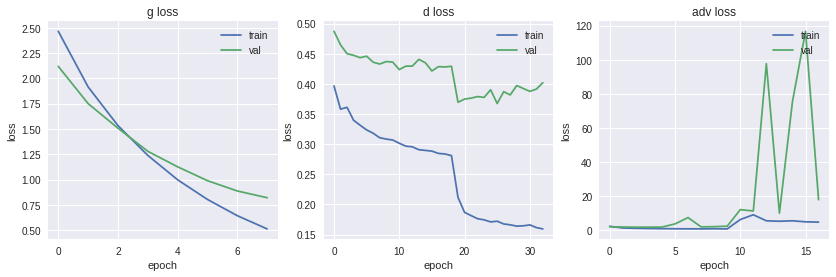

In [258]:
import matplotlib.pyplot as plt 

# summarize history for loss
def plt_losses(loss_history,title):
  plt.plot(loss_history.losses['loss'][:])
  plt.plot(loss_history.losses['val_loss'][:])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  

plt.figure(figsize=(14,4))
plt.subplot(131) #numrows, numcols, fignum
plt_losses(loss_history,'g loss')  
plt.subplot(132)
plt_losses(loss_history_d,'d loss')  
plt.subplot(133)
plt_losses(loss_history_adv,'adv loss') 
plt.show()



[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

gold  x:  ['At', 'the', 'first', 'God', 'made', 'the', 'heaven', 'and', 'the', 'earth.']
gold_styl: ['t_bbe.csv', 'At', 'the', 'first', 'God', 'made', 'the', 'heaven', 'and', 'the']
gold y:  ['At', 'the', 'first', 'God', 'made', 'the', 'heaven', 'and', 'the', 'earth.']
actual y: ['At', 'the', 'first', 'God', 'made', 'the', 'heaven', 'and', 'the', 'earth.', 'cry']

gold  x:  ['In', 'the', '<oov>', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth.']
gold_styl: ['t_kjv.csv', 'In', 'the', '<oov>', 'God', 'created', 'the', 'heaven', 'and', 'the']
gold y:  ['In', 'the', '<oov>', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth.']
actual y: ['In', 'the', '<oov>', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth.', 'relation']

gold  x:  ['And', 'the', 'earth', 'was', 'waste', 'and', 'without', '<oov>', 'and', 'it']
gold_styl: ['t_bbe.csv', 'And', 'the', 'earth', 'was', 'waste', 'an

In [23]:
#print ('eval on train:',model.evaluate([x_train, x_train_d], y_train))
#print ('eval on val:',model.evaluate([x_val, x_val_d], y_val))

s=20
e=s+1
print ('score',model.evaluate([x_train[s:e], x_train_d[s:e]], y_train[s:e],batch_size=batch_size,verbose=0))

show_sample('train',False,s) 


print ('\n COMPARE TO VAL:\n')
print('score',model.evaluate([x_val[s:e], x_val_d[s:e]], y_val[s:e],batch_size=batch_size,verbose=0))
show_sample('val',False,s) 


score 0.006540380418300629


TypeError: ignored

# Error analysis

In [224]:

def show_sample(data_type='val',teacher_forcing=False,sample_ids=[1000],replace_style=None):
  """ 
    teacher_forcing : should we simulate training and feed the input. default False, as for test
  """
  for i in sample_ids:
      data={'train': dataset.result.train,'val':dataset.result.val , 'test':dataset.result.test}
      
      print ('\n')
      one_x= data[data_type][0][i:i+1]

      one_x_d= data[data_type][1][i:i+1]
      if replace_style:
        if dataset.index2word[one_x_d[0,0]]==replace_style:
           print ('No need to replace style, already in',replace_style)
        style_as_text = replace_style
        one_x_d= np.copy(one_x_d)
        one_x_d[0,0]=dataset.word2index[replace_style]
      else:
        style_as_text = dataset.index2word[one_x_d[0][0]]
        
      one_y= data[data_type][2][i:i+1]
      if one_x.shape[0]==0:
        print ('sample out of range',data[data_type][0].shape)
      print ('gold  x: ',dataset.one_x_as_text(one_x))
      #internal debug print ('gold_styl:',dataset.one_x_as_text(one_x_d))
      #internal debug print ('gold y: ',dataset.one_y_as_text(one_y))
      
      
      if teacher_forcing:
        p = model.predict([one_x,one_x_d])
        print ('actual y:',dataset.one_y_as_text(p))  
        print ('used teacher-forcing:',one_x_d[0][0])
      else:
        p = decode_sequence(one_x,style_as_text)
        print ('actual y:',dataset.one_x_as_text(p))   
        print ('used sample:',style_as_text)


#show_sample(data_type='train',sample_ids=[0,8000,16000])#,replace_style='t_bbe.csv')    
#show_sample(data_type='train',sample_ids=[1,8001,16001])#,replace_style='t_bbe.csv')  


for i in [0,1,1000,1001]:
  print ('#'*30,'verb',i,'#'*30)
  show_sample('train',sample_ids=[i,8000+i],teacher_forcing=True,replace_style='t_bbe.csv') 

############################## verb 0 ##############################


No need to replace style, already in t_bbe.csv
gold  x:  At the first God made the heaven and the earth.
actual y: May the first God made the people and the head
used teacher-forcing: 1997.0


gold  x:  In the <oov> God created the heaven and the earth.
actual y: In the <oov> God the the earth and the Gadites
used teacher-forcing: 1997.0
############################## verb 1 ##############################


No need to replace style, already in t_bbe.csv
gold  x:  And the earth was waste and without <oov> and it
actual y: And the earth was on and without <oov> and <oov>
used teacher-forcing: 1997.0


gold  x:  "And the earth was without <oov> <s> <s> <s> <s>
actual y: "And the earth was like <oov> <s> <s> <s> <s>
used teacher-forcing: 1997.0
############################## verb 1000 ##############################


No need to replace style, already in t_bbe.csv
gold  x:  "Then Hamor and Shechem <s> <s> <s> <s> <s> <s>

In [98]:



#a= model.predict([x_train[s:e], x_train_d[s:e]])
#for i in range(dataset.MAX_SEQUENCE_LENGTH):
#  best=np.argmax(a[0,i])
#  print (i,best,dataset.index2word[best],a[0,i,best],a[0,i,0])

from keras.losses import categorical_crossentropy
p=model.predict([x_val,x_val_d])
scores=K.eval(K.sum(categorical_crossentropy(K.constant(p), K.constant(y_val) ),axis=1))
worse_10 = scores.argsort()[::-1][:10]

for i in range(len(worse_10)):
  bad=worse_10[i]
  print (i,'arg',bad,'score',scores[bad],show_sample('val',False,bad))
  


TypeError: ignored

## Error of style disc.

In [0]:
### Error of style discriminator

#print (style_train[:10])
#style_classifier_model.predict(x_train[:10])#, style_train,
